In [1]:
from sympy.physics.quantum.state import Bra, Ket
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import qapply, Bra, Ket
from sympy.matrices import Matrix
from sympy import expand, symbols, exp, I, re, cos, sin, pi
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
from sympy.vector import CoordSys3D

R = CoordSys3D('R')

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

/Users/la-cyrusyc/miniconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here I define the variables that will be used below

In [2]:
Es = symbols("Es", real=True)
Ep = symbols("Ep", real=True)
sss = symbols(r"ss\sigma", real=True)
sps = symbols(r"sp\sigma", real=True)
pps = symbols(r"ps\sigma", real=True)
ppp = symbols(r"pp\pi", real=True)

$$\left|\Phi^k \right \rangle = \frac{1}{\sqrt{L}} \sum_{u=0}^{L-1} e^{-i \frac{2\pi}{L}j u} \left|\phi_{L-u}\right\rangle = \frac{1}{\sqrt{L}} \sum_{u=0}^{L-1} e^{-i k ua}\left|\phi_{L-u}\right\rangle$$ 

In [3]:
r = symbols("r", real=True)
n = 2.00
nc = 6.5
rc = 2.18
ro = 1.536
ao = 1.0
betar = (ro / r) ** n * exp(n * (-((r / rc) ** nc) + (ro / rc) ** nc))

betar = betar.subs(r, ao)

# **1D nanotube/wire**

To solve this problem easily, we can regard the 1D nanotube as a 2D crystal infinite long in one dimension (x axis) and 4 atoms in another dimension (y axis) and wrap the crystal along y axis into a tube and the system has the symmetry equivalent to a torus along the surface of the tube. This approach nicely reframes the problem into a 2D periodic crystal problem, with infinite number of bloch states along x axis and 4 bloch states along another axis.

We start with the energy for 2D periodic S-valent crystal that is easily solved: $$H_k = E_s + 2 ss\sigma (a) * (\cos(ka)+\cos(kb))$$

In [4]:
k = symbols("k")
a, b = symbols("a, b")

Hk_wire = Es + 2*sss*(cos(k*a) + cos(k*b))

Hk_wire = Hk_wire.subs(
    [
        (Es, 0),
        (sss, -4 * betar),
    ]
) / abs(sss.subs(sss, -4 * betar))

I sample the high symmetry k points along four lines for bandstructure and all the allowed k-points for DOS.

In [5]:

# bandstructure

L = int(1e3)

kes = []

for kb in np.linspace(-np.pi/ao, np.pi/ao, 4, endpoint=False):
    
    kas, kbs = np.meshgrid(
        np.linspace(-np.pi/ao, np.pi/ao, L, endpoint=False),
        kb
    )

    ks = np.stack((kas, kbs), axis=-1).reshape(-1, 2)

    path = 0

    kpre = ks[0][0]*R.i + ks[0][1]*R.j

    for ki in tqdm(ks):
        ksub = ki[0]*R.i + ki[1]*R.j
        Hsub = Hk_wire.subs(
            [
                (k*a, ksub&-R.j*ao),
                (k*b, ksub&R.i*ao)
            ]
        )

        path += float((ksub - kpre).magnitude())
        kpre = ksub

        kes.append([path, float(Hsub)])
        
kes = np.array(kes)

# dos

L = int(5e3)

kas, kbs = np.meshgrid(
    np.linspace(-np.pi/ao, np.pi/ao, L, endpoint=False),
    np.linspace(-np.pi/ao, np.pi/ao, 4, endpoint=False)
)

ks = np.stack((kas, kbs), axis=-1).reshape(-1, 2)

KES = []

for ki in tqdm(ks):
    ksub = ki[0]*R.i + ki[1]*R.j
    Hsub = Hk_wire.subs(
        [
            (k*a, ksub&-R.j*ao),
            (k*b, ksub&R.i*ao)
        ]
    )
    KES.append(float(Hsub))

KES = np.array(KES)
emin, emax = KES.min(), KES.max()
erange = emax - emin
bins = np.linspace(emin - erange*0.05, emax + erange*0.05, int(200))
dos, bins = np.histogram(KES, bins=bins)

bin_centers =  (bins[1:]+bins[:-1])*0.5
bin_widths = np.diff(bins)

dos = dos * 2 / (L*4) / bin_widths / 1

# sanity check

np.isclose(np.trapz(dos, bin_centers), 2)

100%|██████████| 20000/20000 [00:07<00:00, 2790.44it/s]


True

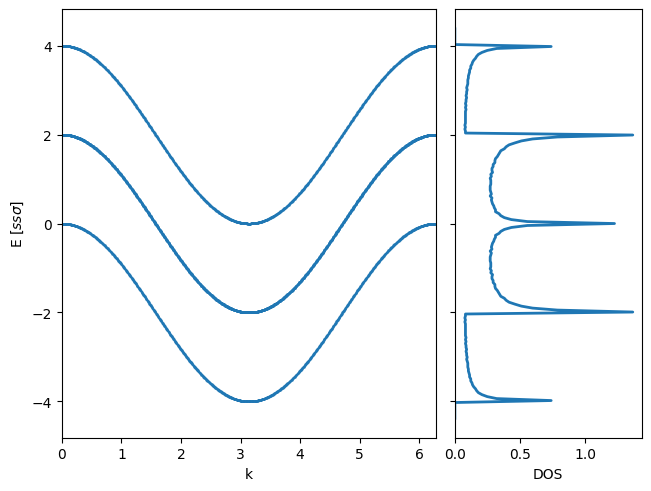

Normalized moment (0): 1.0
Normalized moment (1): -3.1420985299944146e-16
Normalized moment (2): 3.9975697001590835
Normalized moment (3): -5.027357647991063e-15
Normalized moment (4): 37.9336123011127
Normalized moment (5): -5.027357647991063e-14
Normalized moment (6): 470.4719269714405
Normalized moment (7): -6.435017789428561e-13
Normalized moment (8): 6437.918730440973
Normalized moment (9): -7.722021347314273e-12


In [6]:
with plt.style.context('default'):
    
    LINE_WIDTH = 2

    fig, ax = plt.subplot_mosaic("""
                                 ab
                                 """, 
                                 sharey=True,
                                 width_ratios=[1, 0.5],
                                 constrained_layout=True)
    
    i = 'a'

    ax[i].scatter(kes[:, 0], kes[:, 1], s=0.25*LINE_WIDTH)

    ax[i].set(
        xlabel='k',
        xlim=(kes[:, 0].min(), kes[:, 0].max()),
        ylabel='E [$ss\\sigma$]'
    )

    i = 'b'

    ax[i].plot(dos, bin_centers, lw=LINE_WIDTH)

    xlo, xhi = ax[i].get_xlim()
    ax[i].set(
        xlabel='DOS',
        xlim=(0, xhi),
    )
    
    plt.show()

for n in range(10):
    print(f"Normalized moment ({n}):", (dos * bin_centers**n).sum() / dos.sum())

KES_wire = KES
dos_wire = dos
bin_wire = bin_centers

# **2D crystal**

2D crystal is more straight forward. We will just use the solution for 2D crystal and sample lines between high symmetry points $\Gamma, X, M$ for bandstructure and a square in reciprocal space for DOS. 

In [7]:

k = symbols("k")
a, b = symbols("a, b")

Hk_plane = Es + 2*sss*(cos(k*a) + cos(k*b))

Hk_plane = Hk_plane.subs(
    [
        (Es, 0),
        (sss, -4 * betar),
    ]
) / abs(sss.subs(sss, -4 * betar))

Hk_plane

-2.0*cos(a*k) - 2.0*cos(b*k)

In [8]:

# bandstructure
G = [0, 0]
X = np.array([np.pi, 0])/ao
M = np.array([np.pi, np.pi])/ao

npts = int(1e3)

ks = np.concatenate(
    (
        np.linspace(G, X, npts, endpoint=False), 
        np.linspace(X, M, npts, endpoint=False),
        np.linspace(M, G, npts, endpoint=True)
    ), 
    axis=0
)

kes = []
path = 0

kpre = ks[0][0]*R.i + ks[0][1]*R.j

for ki in ks:

    ksub = ki[0]*R.i + ki[1]*R.j
    Hsub = Hk_plane.subs(
        [
            (k*a, ksub&-R.j*ao),
            (k*b, ksub&R.i*ao)
        ]
    )

    path += float((ksub - kpre).magnitude())
    kpre = ksub

    kes.append([path, float(Hsub)])
    
kes = np.array(kes)

# dos

L = int(1e3)

kas, kbs = np.meshgrid(
    np.linspace(-np.pi/ao, np.pi/ao, L, endpoint=False),
    np.linspace(-np.pi/ao, np.pi/ao, L, endpoint=False)
)

ks = np.stack((kas, kbs), axis=-1).reshape(-1, 2)

KES = []

for ki in tqdm(ks):
    ksub = ki[0]*-R.j + ki[1]*R.i
    Hsub = Hk_plane.subs(
        [
            (k*a, ksub&-R.j*ao),
            (k*b, ksub&R.i*ao)
        ]
    )
    KES.append(float(Hsub))

KES = np.array(KES)
emin, emax = KES.min(), KES.max()
erange = emax - emin
bins = np.linspace(emin - erange*0.05, emax + erange*0.05, int(200))
dos, bins = np.histogram(KES, bins=bins)

bin_centers =  (bins[1:]+bins[:-1])*0.5
bin_widths = np.diff(bins)

dos = dos * 2 / (L**2) / bin_widths / 1

# sanity check

np.isclose(np.trapz(dos, bin_centers), 2)

100%|██████████| 1000000/1000000 [07:49<00:00, 2130.48it/s]


True

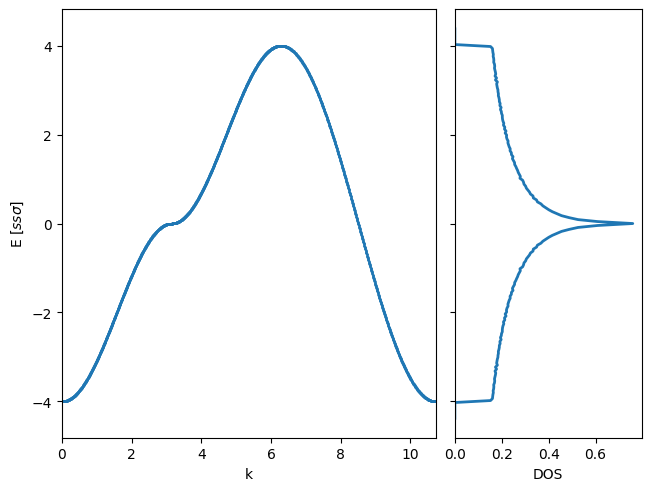

Normalized moment (0): 1.0
Normalized moment (1): -1.5710492649972065e-16
Normalized moment (2): 4.000041851064365
Normalized moment (3): -1.2568394119977652e-15
Normalized moment (4): 35.999157944755964
Normalized moment (5): -3.0164145887946366e-14
Normalized moment (6): 399.9673272868535
Normalized moment (7): -1.6087544473571395e-13
Normalized moment (8): 4899.20546986689
Normalized moment (9): -5.148014231542846e-12


In [9]:
with plt.style.context('default'):
    
    LINE_WIDTH = 2

    fig, ax = plt.subplot_mosaic("""
                                 ab
                                 """, 
                                 sharey=True,
                                 width_ratios=[1, 0.5],
                                 constrained_layout=True)
    
    i = 'a'

    ax[i].scatter(kes[:, 0], kes[:, 1], s=0.25*LINE_WIDTH)

    ax[i].set(
        xlabel='k',
        xlim=(kes[:, 0].min(), kes[:, 0].max()),
        ylabel='E [$ss\\sigma$]'
    )

    i = 'b'

    ax[i].plot(dos, bin_centers, lw=LINE_WIDTH)

    xlo, xhi = ax[i].get_xlim()
    ax[i].set(
        xlabel='DOS',
        xlim=(0, xhi),
    )
    
    plt.show()

for n in range(10):
    print(f"Normalized moment ({n}):", (dos * bin_centers**n).sum() / dos.sum())

KES_plane = KES
dos_plane = dos
bin_plane = bin_centers

We can see that the shapes and characteristics of the density of states look different for 1D wire and 2D plane. The DOS of 1D wire has multiple jumps followed by tails. Planar 2D crystal is characterized by the sudden jump in the DOS as well but followed by satuation instead of depletion. There are called van Hove singularities and could be used to classify the dimensionality of the systems.

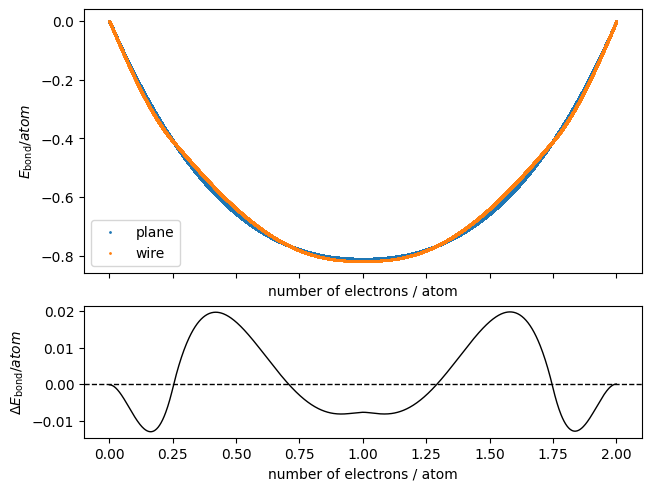

In [20]:

with plt.style.context('default'):
    
    LINE_WIDTH = 1

    fig, ax = plt.subplot_mosaic("""
                                 a
                                 b
                                 """, 
                                 sharex=True,
                                 height_ratios=[1, 0.5],
                                 constrained_layout=True)
    

    

    iax = 'a'

    beplane = np.cumsum(np.sort(KES_plane))/KES_plane.shape[0]
    xplane = np.linspace(0, 2, beplane.shape[0])
    
    ax[iax].plot(xplane, beplane, 'o', label='plane', lw=LINE_WIDTH, ms=LINE_WIDTH)

    bewire = np.cumsum(np.sort(KES_wire))/KES_wire.shape[0]
    xwire = np.linspace(0, 2, bewire.shape[0])

    ax[iax].plot(xwire, bewire, 'o', label='wire', lw=LINE_WIDTH, ms=LINE_WIDTH)

    ax[iax].legend()
    ax[iax].set(
        xlabel='number of electrons / atom',
        ylabel='$E_\\text{bond} / atom$'
    )

    iax = 'b'

    X = np.linspace(0, 2, int(1e3))
    beplane = np.interp(X, xplane, beplane)
    bewire = np.interp(X, xwire, bewire)

    ax[iax].plot(X, bewire - beplane, '-k', lw=LINE_WIDTH)
    ax[iax].axhline(0, ls='--', c='k', lw=LINE_WIDTH)
    # ax[iax].plot(ne, bewire, label='wire', lw=LINE_WIDTH)

    ax[iax].set(
        xlabel='number of electrons / atom',
        ylabel='$\\Delta E_\\text{bond} / atom$'
    )

    plt.show()



These two structures have equal moments up to the third moments (1.0, 0, 4.0, 0). The moments theorem tells us the bond energy curves must at least cross 2 times. By looking at the exact bond energy difference curve in the bottom panel of the plot, there are 4 crossings, more than 2 times and thus consistent with the moment theorem.

In [ ]:


# with plt.style.context('default'):
    
#     LINE_WIDTH = 1

#     fig, ax = plt.subplot_mosaic("""
#                                  a
#                                  b
#                                  """, 
#                                  sharex=True,
#                                  height_ratios=[1, 0.5],
#                                  constrained_layout=True)
    
#     ne = np.linspace(0, 2, int(1e3))

#     iax = 'a'

#     x, y = [], []
#     for i in range(len(dos_plane)):
#         nelec = np.trapz(dos_plane[:i], bin_plane[:i])
#         energy = np.sum(dos_plane[:i] * bin_plane[:i])
#         x.append(nelec)
#         y.append(energy)

#     beplane = np.interp(ne, x, y)
    
#     ax[iax].plot(x, y, 'o', label='plane', lw=LINE_WIDTH, ms=LINE_WIDTH)

    

#     x, y = [], []
#     for i in range(len(dos_wire)):
#         nelec = np.trapz(dos_wire[:i], bin_wire[:i])
#         energy = np.sum(dos_wire[:i] * bin_wire[:i])
#         x.append(nelec)
#         y.append(energy)

#     bewire = np.interp(ne, x, y)

#     ax[iax].plot(x, y, 'o', label='wire', lw=LINE_WIDTH, ms=LINE_WIDTH)

#     ax[iax].legend()
#     ax[iax].set(
#         xlabel='number of electrons / atom',
#         ylabel='$E_\\text{bond} / atom$'
#     )

#     iax = 'b'

#     ax[iax].plot(ne, bewire - beplane, '-k', lw=LINE_WIDTH)
#     ax[iax].axhline(0, ls='--', c='k', lw=LINE_WIDTH)
#     # ax[iax].plot(ne, bewire, label='wire', lw=LINE_WIDTH)

#     ax[iax].set(
#         xlabel='number of electrons / atom',
#         ylabel='$\\Delta E_\\text{bond} / atom$'
#     )

#     plt.show()